In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns


In [2]:
with open('primed_qtable.json', 'rb') as file:
    data = json.load(file)

In [3]:
data_df = pd.DataFrame(data)
type(data_df)

pandas.core.frame.DataFrame

In [11]:
import pickle
granularity = 4.0
HEIGHT= int(26*granularity)
WIDTH = int(26*granularity)
def load_qtable(filename="qtable.pkl"):
    with open(filename, "rb") as f:
        qtable = pickle.load(f)
    return qtable

q_table = load_qtable(filename="primed_qtable_5G.pkl")

In [12]:
q_table

,0,1,2,3,4,5,6
0,0.871180,0.921008,0.120122,0.551440,0.781159,0.337377,0.622462
1,0.194833,0.901935,0.390293,0.648403,0.273902,0.033208,0.821816
2,0.027383,0.110266,0.473433,0.945671,0.040129,0.391522,0.376239
3,0.618430,0.482499,0.908211,0.005446,0.470757,0.309833,0.148117
4,0.919738,0.713444,0.137041,0.290305,0.645541,0.505799,0.259747
...,...,...,...,...,...,...,...
86523,0.261899,0.980174,0.869923,0.270819,0.555197,0.239901,0.630639
86524,0.197992,0.758463,0.343007,0.948178,0.162020,0.253175,0.409414
86525,0.419256,0.646476,0.874264,0.400473,0.058813,0.819566,0.386600
86526,0.067202,0.268829,0.203536,0.051664,0.362771,0.554395,0.248334


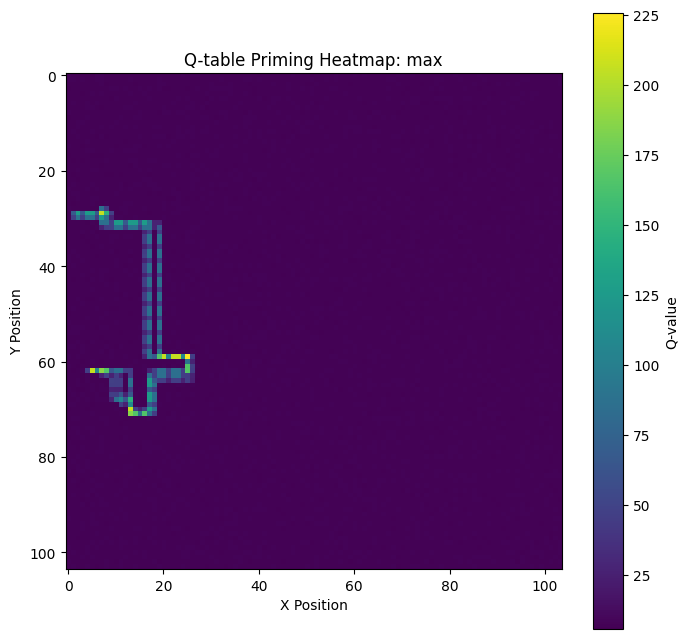

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qtable_heatmap(qtable, mode="sum"):
    collapsed = np.zeros((HEIGHT, WIDTH))

    #encoding: ((((x,y)*2 + cart)*2 + items)*2 + checkout)

    for x in range(HEIGHT):
        for y in range(WIDTH):
            cell_value = 0
            # binary has_cart
            for cart in [0, 1]:
                # binary has_items
                for items in [0, 1]:
                    # binary has_checkour
                    for checkout in [0, 1]:
                        idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)

                        if mode == "sum":
                            cell_value += qtable.loc[idx].sum() #sum of actions
                        elif mode == "max":
                            cell_value += qtable.loc[idx].max() #max of actions
                        else:
                            raise ValueError("mode wrong")

            collapsed[x, y] = cell_value

    plt.figure(figsize=(8, 8))
    plt.imshow(collapsed.T, origin="lower", aspect="equal")
    plt.colorbar(label="Q-value")
    
    ax = plt.gca()
    ax.invert_yaxis()

    plt.title(f"Q-table Priming Heatmap: {mode}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

plot_qtable_heatmap(qtable=q_table, mode="max")


In [16]:
from collections import deque

def top_checkpoints(qtable, n = 5, mode="sum"):
    collapsed = np.zeros((HEIGHT, WIDTH))
    vector = [0,0,0,0,0,0,0]
    top_checkpoints = []


    # add empty checkpoints
    for i in range(n):
        top_checkpoints.append(vector)

    # compute top5 cells
    for x in range(HEIGHT):
        for y in range(WIDTH):
            cell_value = 0
            for cart in [0, 1]:
                for items in [0, 1]:
                    for checkout in [0, 1]:
                        idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)
                        
                        if mode == "sum": # if sum
                            cell_value += qtable.loc[idx].sum()
                        elif mode == "max": # if max
                            cell_value += qtable.loc[idx].max()
                        else:
                            raise ValueError("mode wrong")
                        
                        vector = [idx, x, y, cart, items, checkout, cell_value]

                        # replace empty or lower checkpoints
                        for i, item in enumerate(top_checkpoints):
                            if cell_value > top_checkpoints[i][-1]:
                                top_checkpoints[i] = vector
                                break

            collapsed[x, y] = cell_value

    return top_checkpoints #return top n checkpoints

checkpoints = top_checkpoints(q_table, n = 5, mode = "sum")
print(checkpoints)


[[21279, 25, 59, 1, 1, 1, np.float64(325.09482496872516)], [6895, 8, 29, 1, 1, 1, np.float64(249.60670291516143)], [11383, 13, 70, 1, 1, 1, np.float64(247.23019788437034)], [16287, 19, 59, 1, 1, 1, np.float64(228.68515297449716)], [17119, 20, 59, 1, 1, 1, np.float64(228.41283719093857)]]


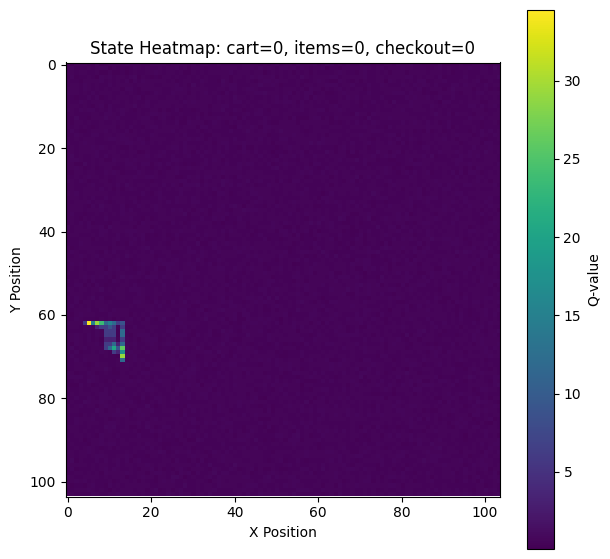

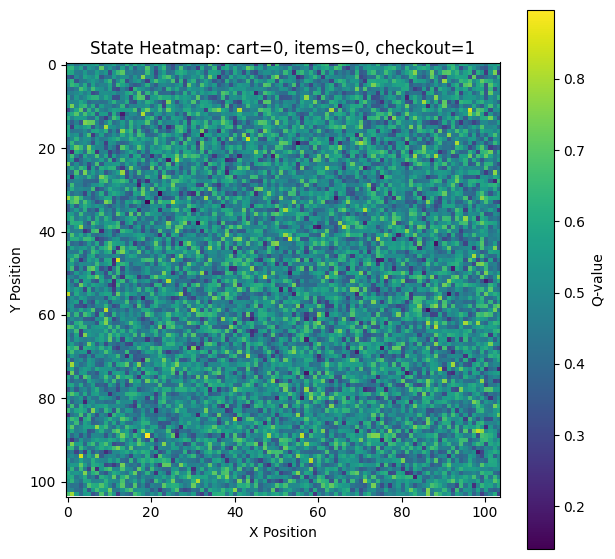

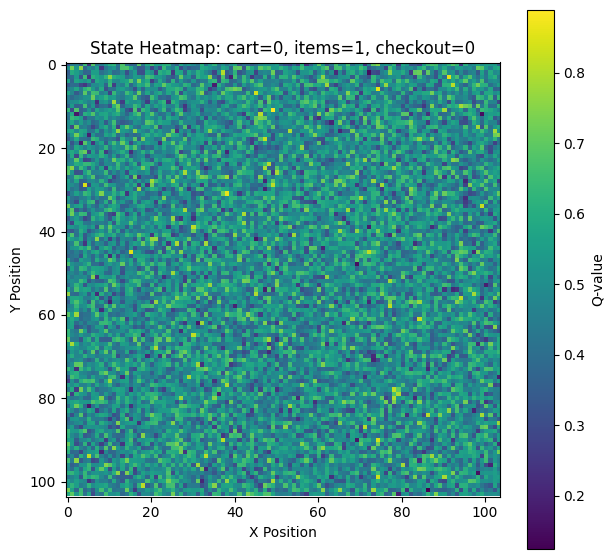

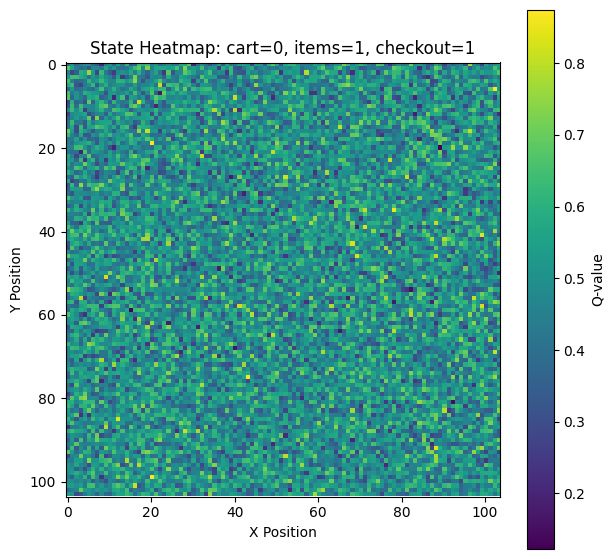

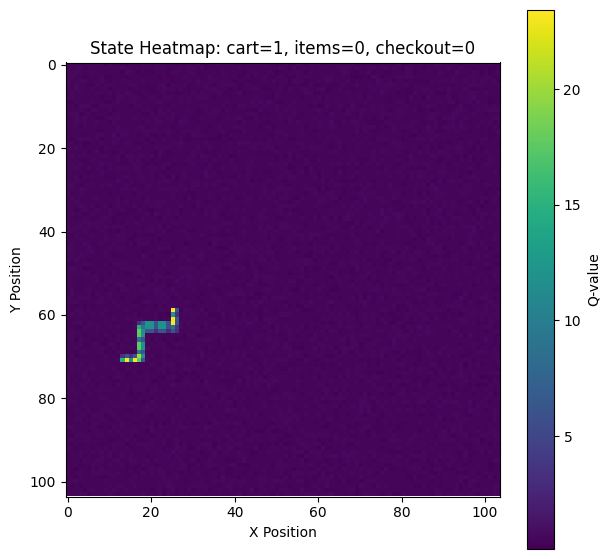

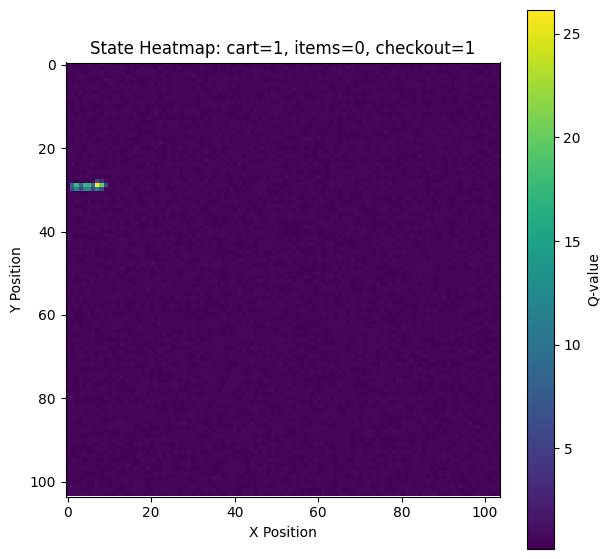

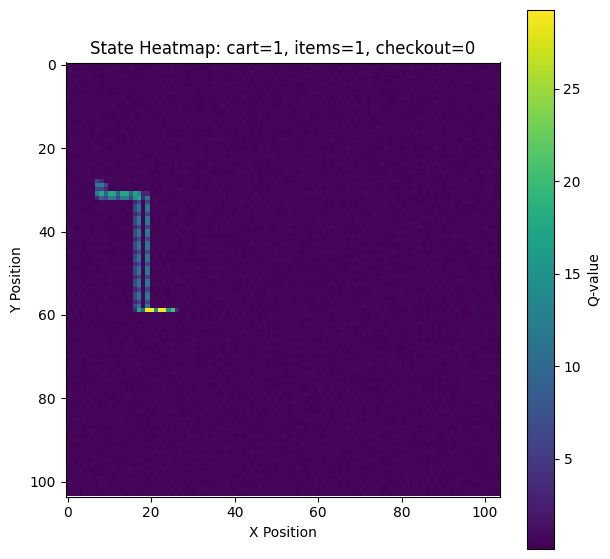

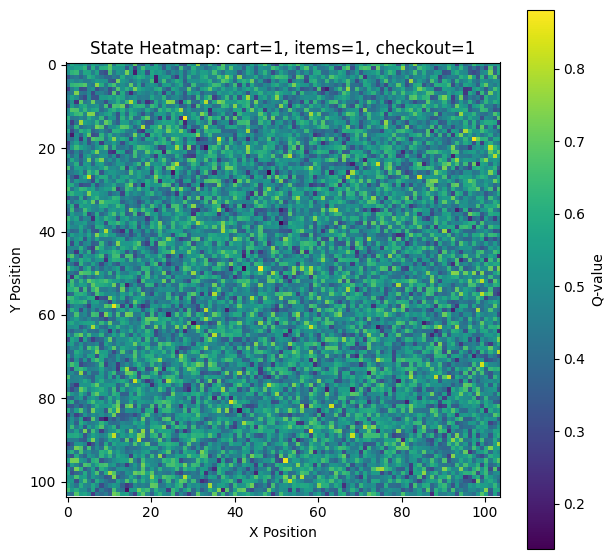

In [17]:
import itertools

def plot_qtable_states(qtable):
    binary_states = list(itertools.product([0,1], repeat=3))

    for cart, items, checkout in binary_states:

        heatmap = np.zeros((HEIGHT, WIDTH))

        for x in range(HEIGHT):
            for y in range(WIDTH):

                idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)
                qvals = qtable.loc[idx].values
                heatmap[x, y] = qvals.mean()

        plt.figure(figsize=(7, 7))
        plt.imshow(heatmap.T, origin="lower", aspect="equal")
        plt.colorbar(label="Q-value")

        ax = plt.gca()
        ax.invert_yaxis()

        plt.title(f"State Heatmap: cart={cart}, items={items}, checkout={checkout}")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")

        plt.show()

plot_qtable_states(q_table)
